### Parseia IDs de usuários beta e prepara consumo do MixPanel

In [4]:
import csv
import pdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import requests
from requests.auth import HTTPBasicAuth
import json

api_url = "https://data.mixpanel.com/api/2.0/export"
api_secret = None

def parse_api_data(http_response):
  data = http_response.text.splitlines()
  records = [json.loads(rec) for rec in data]
  
  return records

def request_events(
    from_date="2024-01-01", 
    to_date="2024-01-01", 
    events=[], 
    where='', 
    limit=None
):
    response = requests.post(
        api_url, 
        data={
            "from_date": from_date,
            "to_date": to_date,
            "event": json.dumps(events),
            "where": where,
            "limit": limit,
        },
        auth=HTTPBasicAuth(api_secret,'')
    )
    return response

def get_events_from_file(file_name):
    with open(file_name, "r") as file:
        events_list = json.load(file)

    return events_list

def get_beta_testers_ids():
    users_ids = []

    with open('beta_testers_ids.masked.txt', mode='r') as file:
        reader = csv.reader(file)
        for row in reader:
            users_ids.append(row[0])

    return users_ids

# only necessary in this case because the event being analyzed do not have information
# about the user organization, in the future we can simply add a property informing the org id
beta_testers_ids = get_beta_testers_ids()

print("número de usuários betas salvos", len(beta_testers_ids))### Parseia IDs de usuários beta e prepara consumo do MixPanelfilters_results = parse_api_data(


número de usuários betas salvos 79193


### Consome API do Mixpanel
#### Busca por eventos de utilização de filtros

In [5]:
filters_results = parse_api_data(
    request_events(
        from_date="2024-10-08",
        to_date="2024-10-21",
        events=["Activity Exercise Bank - Filtered Exercises"],
    )
) if api_secret else get_events_from_file("filters_events.masked.json")

print("número de eventos de filtragem recebidos do mixpanel", len(filters_results))

número de eventos de filtragem recebidos do mixpanel 41516


### Verifica se há diferença na adoção do filtro pelos docentes de cada grupo
#### A proporção de adoção do filtro é diferente entre usuários beta?

In [ ]:
def get_users_adoption_by_group():
    data_by_user_id = {};

    for event in filters_results:
        user_id = event["properties"].get("$user_id")

        if not user_id:
            continue

        user_data = data_by_user_id.get(user_id)

        if not user_data:
            data_by_user_id[user_id] = event["properties"]["Used Filter"] == "Nível de dificuldade"
            
            
    data = []
            
    for user_id in data_by_user_id.keys():
        data.append({
            "group": "treatment" if user_id in beta_testers_ids else "control",
            "adopted": data_by_user_id[user_id]
        })
        
    return data

adoption_df = pd.DataFrame(get_users_adoption_by_group())

adopt_contingency = pd.crosstab(adoption_df['group'], adoption_df['adopted'])

print(adopt_contingency)

adopt_chi2, adopt_p_value, adopt_dof, adopt_expected = stats.chi2_contingency(adopt_contingency)

print(f"\nchi-quadrado: {adopt_chi2}")
print(f"p-valor: {adopt_p_value}")
print(f"graus de liberdade: {adopt_dof}")
print(f"frequências esperadas: {adopt_expected}")

alpha = 0.05

if adopt_p_value < alpha:
    print(f"\nhá uma diferença entre a adoção do filtro pelos grupos.")
else:
    print(f"\nnão há uma diferença entre a adoção do filtro pelos grupos.")

adopted    False  True 
group                  
control     2142    281
treatment    391     50

chi-quadrado: 0.005731640997952244
p-valor: 0.9396517278466324
graus de liberdade: 1
frequências esperadas: [[2142.96752793  280.03247207]
 [ 390.03247207   50.96752793]]

não há uma diferença significativa entre a adoção do filtro pelos grupos.


### Calcula o número de utilizações do filtro de nível de dificuldade por cada docente único

In [8]:
experiment_users_ids = [] # guarda os ids dos usuários que participarão do experimento

def get_filter_uses_by_group():
    occs_by_user_id = {}

    for event in filters_results:
        if event["properties"]["Used Filter"] != "Nível de dificuldade":
            continue

        user_id = event["properties"].get("$user_id")

        if not user_id:
            continue

        if not occs_by_user_id.get(user_id):
            occs_by_user_id[user_id] = 1
        else:
            occs_by_user_id[user_id] = occs_by_user_id[user_id] + 1

    data = {
        "control": [],
        "treatment": [],
    }

    for user_id in occs_by_user_id.keys():
        experiment_users_ids.append(user_id)
        data["treatment" if user_id in beta_testers_ids else "control"]\
            .append({ "id": user_id, "uses": occs_by_user_id[user_id]})

    return data

parsed_filters_data = get_filter_uses_by_group()

for group in parsed_filters_data.keys():
    print("grupo", group, len(parsed_filters_data[group]), "docentes")
#     print("Nº de usos:", [user["uses"] for user in parsed_filters_data[group]])

grupo control 281 docentes
grupo treatment 50 docentes


### Remove outliers, plota distribuição dos grupos e testa normalidade

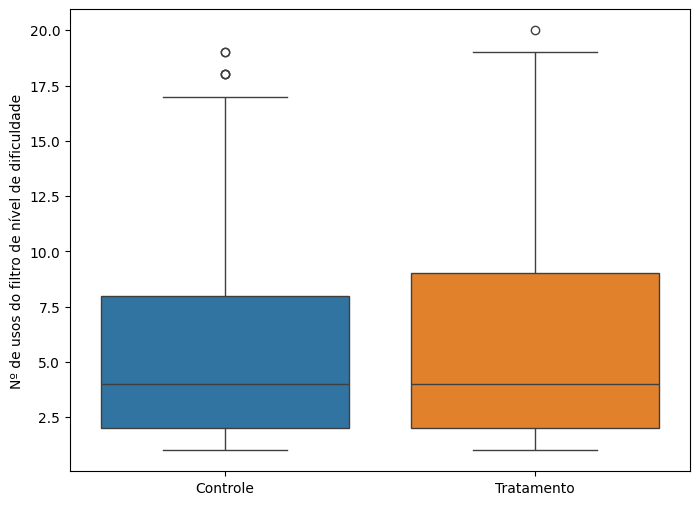

In [9]:
def remove_outliers(df, metric):
    Q1 = df[metric].quantile(0.25)
    Q3 = df[metric].quantile(0.75)
    IQR = Q3 - Q1
    bot_threshold = Q1 - 1.5 * IQR
    top_threshold = Q3 + 1.5 * IQR
    return df[(df[metric] >= bot_threshold) & (df[metric] <= top_threshold)]

uses_num_ct_df = \
    remove_outliers(
        pd.DataFrame(parsed_filters_data["control"]),
        "uses"
    )
uses_num_trt_df = \
    remove_outliers(
        pd.DataFrame(parsed_filters_data["treatment"]),
        "uses"
    )

uses_boxplot = pd.concat([uses_num_ct_df["uses"], uses_num_trt_df["uses"]], axis=1)
uses_boxplot.columns = ['Controle', 'Tratamento']

plt.figure(figsize=(8, 6))
sns.boxplot(data=uses_boxplot)
plt.title('')
plt.ylabel('Nº de usos do filtro de nível de dificuldade')
plt.show()

In [10]:
uses_num_ct_df.describe()

,uses
count,254.000000
mean,5.657480
std,4.244131
min,1.000000
25%,2.000000
50%,4.000000
75%,8.000000
max,19.000000


In [11]:
uses_num_trt_df.describe()

,uses
count,45.000000
mean,6.111111
std,4.858087
min,1.000000
25%,2.000000
50%,4.000000
75%,9.000000
max,20.000000


controle: distribuição não normal
tratamento: distribuição não normal


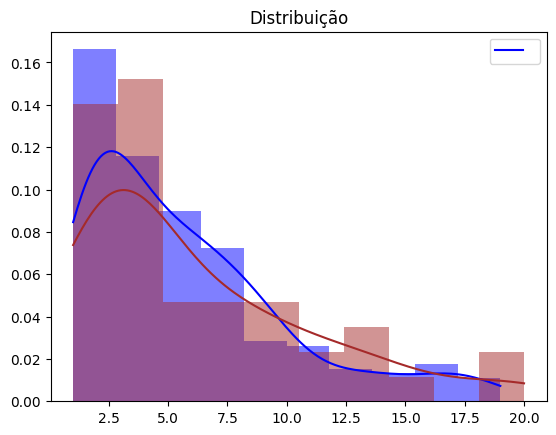

In [12]:
# ----------- TESTES DE NORMALIDADE -------------

uses_ct_stat, uses_ct_p_value = stats.normaltest(uses_num_ct_df["uses"])
uses_trt_stat, uses_trt_p_value = stats.normaltest(uses_num_trt_df["uses"])

if uses_ct_p_value > 0.05:
    print("controle: distribuição normal")
else:
    print("controle: distribuição não normal")

if uses_trt_p_value > 0.05:
    print("tratamento: distribuição normal")
else:
    print("tratamento: distribuição não normal")
    
# ------------------------------------------------

sns.histplot(uses_num_ct_df["uses"], kde=True, color='blue', label='', bins=10, stat='density', linewidth=0)
sns.histplot(uses_num_trt_df["uses"], kde=True, color='brown', label='', bins=10, stat='density', linewidth=0)

plt.title('Distribuição')
plt.xlabel('')
plt.ylabel('')
plt.legend([''])

plt.show()

### Verifica se há diferença no número de utilizações do filtro de nível de dificuldade entre os grupos
#### Docentes beta utilizam o filtro mais ou menos vezes que o resto da base?

In [ ]:
uses_u_stat, usesup_value = stats.mannwhitneyu(
    uses_num_ct_df["uses"], 
    uses_num_trt_df["uses"], 
    alternative="two-sided"
)

print(f"u-statistic: {uses_u_stat:.4f} up-value: {usesup_value:.4f}")

alpha = 0.05

if usesup_value < alpha:
    print("diferença estatistica encontrada")
else:
    print("nenhuma diferença estatistica encontrada")

u-statistic: 5511.0000 up-value: 0.7014
nenhuma diferença estatisticamente significativa


### Verifica se há diferença no número de atividades criadas por cada docente
#### Docentes beta criam o mesmo número de atividades que o resto da base?

In [14]:
hw_results = parse_api_data(
    request_events(
        from_date="2024-10-08",
        to_date="2024-10-21",
        events=["Homework Scheduled"],
    )
) if api_secret else get_events_from_file("homework_events.masked.json")


print("número de eventos de criação de atividades recebidos do mixpanel", len(hw_results))

número de eventos de criação de atividades recebidos do mixpanel 31352


In [15]:
def get_activity_creations_for_each_teacher():
    occs_by_user_id = {}

    for event in hw_results:
        user_id = event["properties"].get("$user_id")

        if not user_id:
            continue
            
        if user_id not in experiment_users_ids:
            continue

        if occs_by_user_id.get(user_id):
            occs_by_user_id[user_id] = occs_by_user_id[user_id] + 1
        else:
            occs_by_user_id[user_id] = 1

    data = {
        "control": [],
        "treatment": [],
    }

    for user_id in occs_by_user_id.keys():
        data["treatment" if user_id in beta_testers_ids else "control"]\
            .append({ "id": user_id, "activities_created": occs_by_user_id[user_id]})

    return data

acts_by_group = get_activity_creations_for_each_teacher()

for group in acts_by_group.keys():
    print("grupo ", group, len(acts_by_group[group]), "docentes:", )
    print("Nº de atividades criadas:", [user["activities_created"] for user in acts_by_group[group]])

grupo  control 225 docentes:
Nº de atividades criadas: [20, 18, 9, 39, 9, 15, 19, 15, 2, 3, 6, 20, 7, 9, 12, 2, 12, 12, 2, 7, 6, 11, 10, 10, 13, 4, 2, 9, 15, 35, 5, 5, 15, 5, 4, 8, 15, 7, 10, 5, 8, 8, 15, 3, 7, 9, 24, 43, 5, 110, 38, 3, 4, 5, 9, 17, 1, 23, 1, 7, 13, 5, 1, 8, 2, 15, 6, 2, 3, 9, 41, 33, 9, 4, 36, 3, 5, 2, 2, 13, 15, 8, 12, 18, 2, 1, 7, 17, 3, 8, 3, 12, 6, 5, 2, 2, 11, 9, 2, 7, 11, 6, 7, 7, 49, 16, 6, 11, 19, 3, 11, 17, 8, 7, 2, 3, 3, 16, 4, 9, 13, 2, 7, 7, 4, 5, 12, 12, 5, 13, 14, 8, 24, 13, 1, 2, 17, 15, 17, 10, 7, 3, 7, 3, 4, 3, 1, 1, 2, 16, 36, 20, 6, 7, 36, 5, 4, 9, 2, 6, 5, 6, 2, 2, 10, 3, 7, 8, 5, 9, 14, 23, 5, 7, 23, 12, 7, 4, 2, 2, 8, 1, 3, 20, 7, 1, 7, 2, 1, 4, 7, 10, 29, 24, 24, 4, 2, 2, 2, 3, 9, 2, 3, 12, 3, 16, 10, 1, 3, 12, 6, 6, 2, 3, 8, 10, 3, 2, 2, 1, 2, 1, 11, 1, 4]
grupo  treatment 44 docentes:
Nº de atividades criadas: [3, 1, 4, 19, 2, 2, 16, 3, 12, 14, 3, 8, 1, 28, 3, 23, 20, 6, 7, 27, 6, 29, 15, 7, 19, 12, 2, 5, 1, 3, 4, 4, 7, 2, 2, 2, 8, 6, 6, 6, 8,

controle: distribuição não normal
tratamento: distribuição não normal


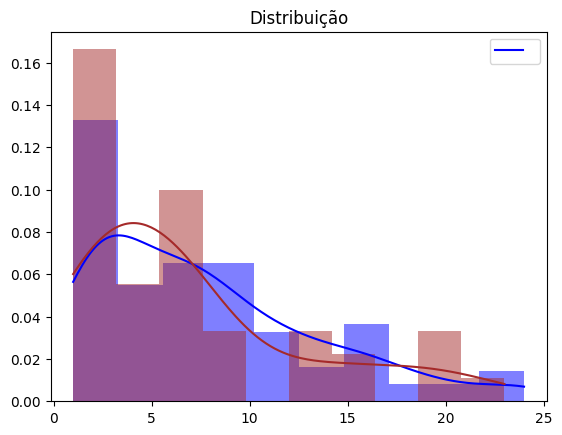

In [16]:
acts_num_ct_df = remove_outliers(
    pd.DataFrame(acts_by_group["control"]),
    "activities_created"
)
acts_num_trt_df = remove_outliers(
    pd.DataFrame(acts_by_group["treatment"]),
    "activities_created"
)

# ----------- TESTES DE NORMALIDADE -------------

acts_ct_stat, acts_ct_p_value = stats.normaltest(acts_num_ct_df["activities_created"])
acts_trt_stat, acts_trt_p_value = stats.normaltest(acts_num_trt_df["activities_created"])

if acts_ct_p_value > 0.05:
    print("controle: distribuição normal")
else:
    print("controle: distribuição não normal")

if acts_trt_p_value > 0.05:
    print("tratamento: distribuição normal")
else:
    print("tratamento: distribuição não normal")
    
# ------------------------------------------------


sns.histplot(acts_num_ct_df["activities_created"], kde=True, color='blue', label='', bins=10, stat='density', linewidth=0)
sns.histplot(acts_num_trt_df["activities_created"], kde=True, color='brown', label='', bins=10, stat='density', linewidth=0)

plt.title('Distribuição')
plt.xlabel('')
plt.ylabel('')
plt.legend([''])

plt.show()

In [ ]:
acts_u_stat, acts_up_value = stats.mannwhitneyu(acts_num_ct_df["activities_created"], acts_num_trt_df["activities_created"], alternative="two-sided")

print(f"u-statistic: {acts_u_stat:.4f} up-value: {acts_up_value:.4f}")

alpha = 0.05

if acts_up_value < alpha:
    print("diferença na criação de atividades pelos docentes de cada grupo")
else:
    print("nenhuma diferença na criação de atividades pelos docentes de cada grupo")

u-statistic: 4797.0000 up-value: 0.3166
nenhuma diferença estatisticamente significativa na criação de atividades pelos docentes de cada grupo
